# Environment Analysis

<ul>
<li>As a whole, there does not appear to be any extreme outliers or trends regarding the environment in car crash injuries. While there are a few insights, the severity of injury appears to rely on other factors outside of the environment.</li>
<li>Most injuries occur between 25 - 45 MPH speed limit zones. However that does not necessarily mean they are the most dangerous, the are instead the most common speed limits and therefore you are going to have more accidents</li>
<li>One of the major takeaways from this is that injury severity does increase as you enter higher speed limit zones such as 60MPH. This makes sense as the vehicle is traveling faster, therefore leading to a more forceful injury that can translate in to more severe injuries.</li>
<li>The total number of injuries tend to increase towards the end of the year, this makes sense due to the increase of traffic during the holidays. On top of that, these are icier months in MD which create more dangerous road conditions</li>
<li>Injury severity is slightly higher in Spring months, this is likely due to the increase in rain and therefore more dangerous road conditions</li>
</ul>

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import numpy as np
import geoviews as gv
import requests
import hvplot.pandas
from geoviews import opts

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Data Cleaning

In [23]:
raw_data_path = ("Resources/Crash_Reporting_-_Drivers_Data.csv")
raw_data_df = pd.read_csv(raw_data_path, dtype=str, header=0, low_memory=False, delimiter=',')

# Splitting Date/Time into two separate columns
split_data = raw_data_df['Crash Date/Time'].str.split(' ', n=1, expand=True)
raw_data_df['Date'] = split_data[0]
raw_data_df['Time'] = split_data[1]

# Converting Injury Severity to number values
severity_scale = {
    'NO APPARENT INJURY': 0,
    'POSSIBLE INJURY': 1,
    'SUSPECTED MINOR INJURY': 2,
    'SUSPECTED SERIOUS INJURY': 3,
    'FATAL INJURY': 4
}
raw_data_df['Injury Severity Scale'] = raw_data_df['Injury Severity'].map(severity_scale)

# Ensuring specific columns are numerical data types
raw_data_df['Injury Severity Scale'] = pd.to_numeric(raw_data_df['Injury Severity Scale'], errors='coerce').fillna(0).astype(int)
raw_data_df['Latitude'] = pd.to_numeric(raw_data_df['Latitude'], errors='coerce').fillna(0).astype(float)
raw_data_df['Longitude'] = pd.to_numeric(raw_data_df['Longitude'], errors='coerce').fillna(0).astype(float)

In [24]:
raw_data_df.columns

Index(['Report Number', 'Local Case Number', 'Agency Name', 'ACRS Report Type',
       'Crash Date/Time', 'Route Type', 'Road Name', 'Cross-Street Type',
       'Cross-Street Name', 'Off-Road Description', 'Municipality',
       'Related Non-Motorist', 'Collision Type', 'Weather',
       'Surface Condition', 'Light', 'Traffic Control',
       'Driver Substance Abuse', 'Non-Motorist Substance Abuse', 'Person ID',
       'Driver At Fault', 'Injury Severity', 'Circumstance',
       'Driver Distracted By', 'Drivers License State', 'Vehicle ID',
       'Vehicle Damage Extent', 'Vehicle First Impact Location',
       'Vehicle Second Impact Location', 'Vehicle Body Type',
       'Vehicle Movement', 'Vehicle Continuing Dir', 'Vehicle Going Dir',
       'Speed Limit', 'Driverless Vehicle', 'Parked Vehicle', 'Vehicle Year',
       'Vehicle Make', 'Vehicle Model', 'Equipment Problems', 'Latitude',
       'Longitude', 'Location', 'Date', 'Time', 'Injury Severity Scale'],
      dtype='object')

In [25]:
environment_data_df = raw_data_df[['Injury Severity','Injury Severity Scale','Date', 'Time', 'Speed Limit', 'Weather','Driver At Fault', 'Surface Condition','Light', 'Traffic Control', 'Driver At Fault' ,'Latitude', 'Longitude' ]]

environment_data_df.head()

,Injury Severity,Injury Severity Scale,Date,Time,Speed Limit,Weather,Driver At Fault,Surface Condition,Light,Traffic Control,Driver At Fault,Latitude,Longitude
0,NO APPARENT INJURY,0,01/03/2024,02:55:00 PM,0,CLOUDY,Yes,NaN,DAYLIGHT,NO CONTROLS,Yes,39.165005,-77.249310
1,NO APPARENT INJURY,0,12/16/2023,12:36:00 PM,35,CLEAR,No,DRY,DAYLIGHT,TRAFFIC SIGNAL,No,39.178776,-77.267190
2,SUSPECTED MINOR INJURY,2,12/29/2023,12:00:00 PM,35,CLEAR,No,DRY,DAYLIGHT,TRAFFIC SIGNAL,No,39.123574,-77.231769
3,NO APPARENT INJURY,0,11/05/2023,09:07:00 PM,40,CLEAR,No,DRY,DARK LIGHTS ON,NO CONTROLS,No,39.211742,-77.171461
4,NO APPARENT INJURY,0,11/18/2023,12:40:00 AM,20,RAINING,Yes,WET,DARK LIGHTS ON,YIELD SIGN,Yes,39.228915,-77.289091


# Visualization

In [26]:
# Islolating only reports with injuries

injuries_filtered = environment_data_df[environment_data_df['Injury Severity'] != 'NO APPARENT INJURY']

In [27]:
# Isolating Fatal Injuries

fatal_injuries = injuries_filtered[injuries_filtered['Injury Severity Scale'] == 4]


## Speed Limit

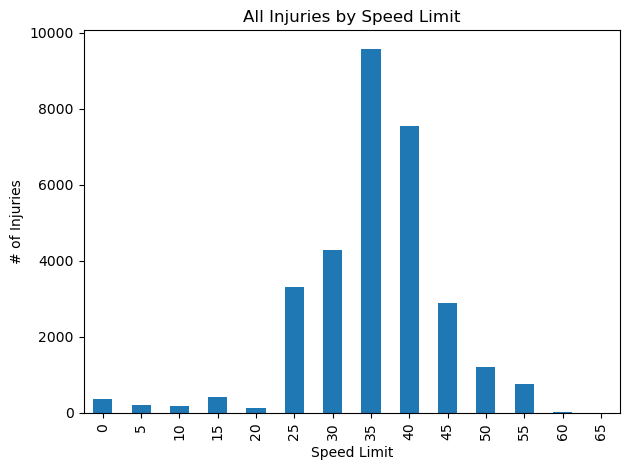

Speed Limit
0      364
5      203
10     189
15     409
20     129
25    3316
30    4288
35    9590
40    7541
45    2886
50    1216
55     767
60      15
65       7
Name: count, dtype: int64

In [28]:
# All Injuries by Speed Limit
speed_counts = injuries_filtered['Speed Limit'].value_counts()
speed_counts.index = pd.to_numeric(speed_counts.index)
speed_counts = speed_counts.sort_index()

speed_chart = speed_counts.plot(kind='bar')

plt.title("All Injuries by Speed Limit")
plt.xlabel('Speed Limit')
plt.ylabel('# of Injuries')
plt.savefig("Resources/Images/speed_chart.png")
plt.tight_layout()
plt.show()

speed_counts

In [29]:
## Is there a relationship between 35 MPH and Injury Severity?

grouped_df = injuries_filtered.groupby("Injury Severity")

#Get counts for 35 MPH and injury severity and puts them into series
mph = grouped_df["Speed Limit"].value_counts()
Injury_Severity_mph = injuries_filtered["Injury Severity"].value_counts()

mph_injury_percentages = []

#Calculate percentages of in-state injuries for each injury type
for injury_type in Injury_Severity_mph.index:
    mph_injury_percentages.append(mph[injury_type]["35"] * 100 / Injury_Severity_mph[injury_type]) 


#Calcuate expected values based on # of 35 MPH accidents
expected_value_percentage_MPH = len(injuries_filtered.loc[injuries_filtered["Speed Limit"] == "35"]) / len(injuries_filtered) * 100
expected_values_MPH = expected_value_percentage_MPH * Injury_Severity_mph / 100

expected_value_percentage_MPH

#Calculate observed values
observed_values_MPH = Injury_Severity_mph * mph_injury_percentages / 100

stats.chisquare(observed_values_MPH, expected_values_MPH)

# There is a significant difference

Power_divergenceResult(statistic=16.949432291693512, pvalue=0.0007238694194865786)

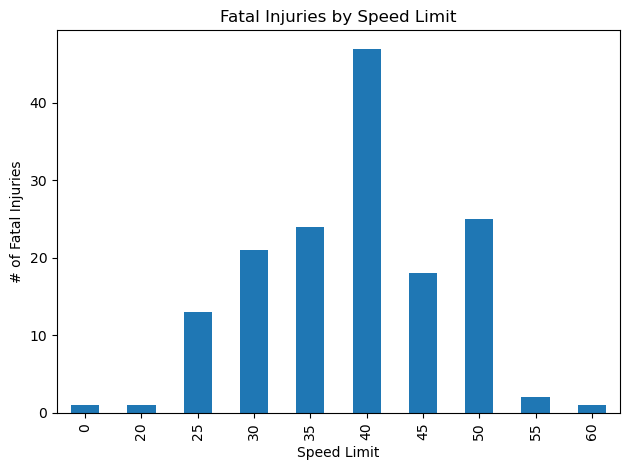

In [30]:
# Fatal Injuries by Speed Limit
fatal_speed_counts = fatal_injuries['Speed Limit'].value_counts()
fatal_speed_counts.index = pd.to_numeric(fatal_speed_counts.index)
fatal_speed_counts = fatal_speed_counts.sort_index()

fatal_speed_chart = fatal_speed_counts.plot(kind='bar')

plt.title("Fatal Injuries by Speed Limit")
plt.xlabel('Speed Limit')
plt.ylabel('# of Fatal Injuries')
plt.savefig("Resources/Images/fatal_speed_chart.png")
plt.tight_layout()
plt.show()

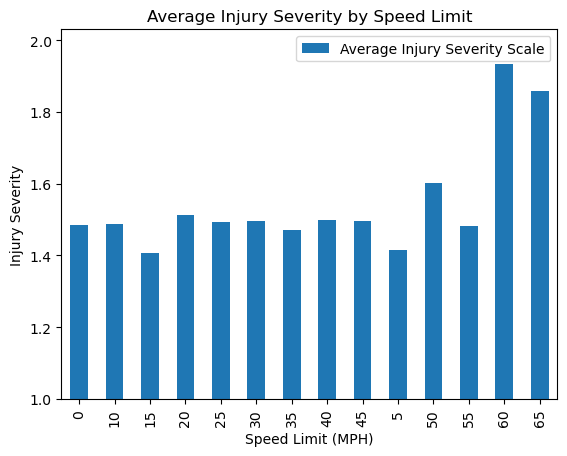

,Average Injury Severity Scale
Speed Limit,
0,1.483516
10,1.486772
15,1.405868
20,1.511628
25,1.491858
30,1.494869
35,1.470594
40,1.498210
45,1.495842


In [31]:
# Injury Severity Speed Limit Average

speed_avg_injury_severity = injuries_filtered.groupby('Speed Limit')['Injury Severity Scale'].mean().reset_index()

speed_avg_injury_severity.columns = ['Speed Limit', 'Average Injury Severity Scale']

speed_avg_injury_severity_indexed = speed_avg_injury_severity.set_index('Speed Limit')

speed_avg_injury_severity_indexed_chart = speed_avg_injury_severity_indexed.plot(kind='bar')


plt.xlabel('Speed Limit (MPH)')
plt.ylabel('Injury Severity')
plt.title('Average Injury Severity by Speed Limit')
plt.ylim(1)
plt.savefig("Resources/Images/average_injury_severity_by_speed.png")
plt.show()

speed_avg_injury_severity_indexed


## Date

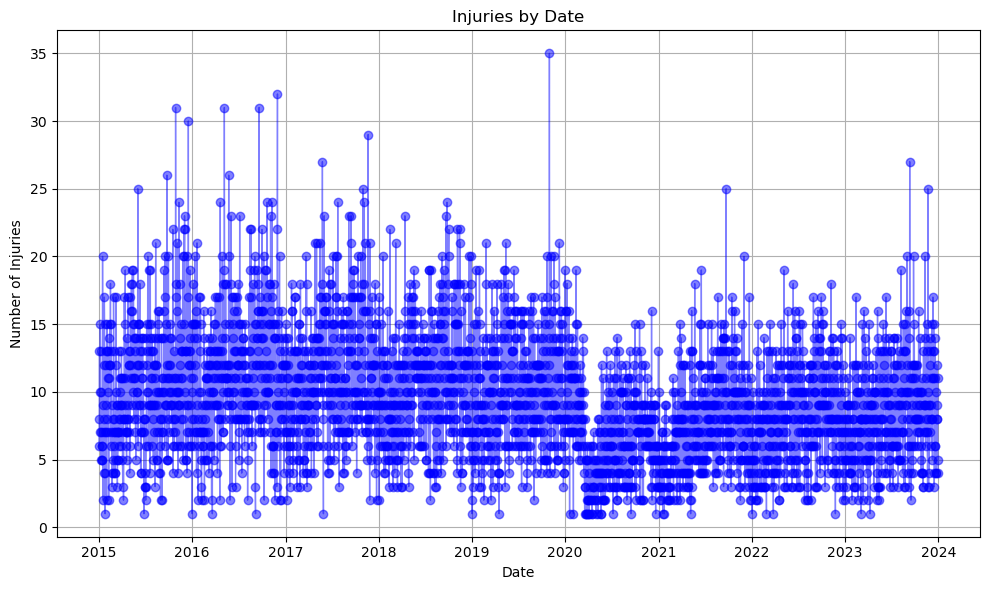

In [32]:
# All Injuries by Date

injuries_filtered['Date'] = pd.to_datetime(injuries_filtered['Date'])

injuries_by_date = injuries_filtered.groupby('Date').size()

injuries_by_date = injuries_by_date.sort_index()

plt.figure(figsize=(10, 6))
plt.plot(injuries_by_date.index, injuries_by_date.values, marker='o', linestyle='-', color='blue', alpha=0.5, linewidth=1)  

plt.title('Injuries by Date')
plt.xlabel('Date')
plt.ylabel('Number of Injuries')

plt.grid(True) 
plt.tight_layout()
plt.savefig("Resources/Images/injuries_by_date.png")
plt.show()

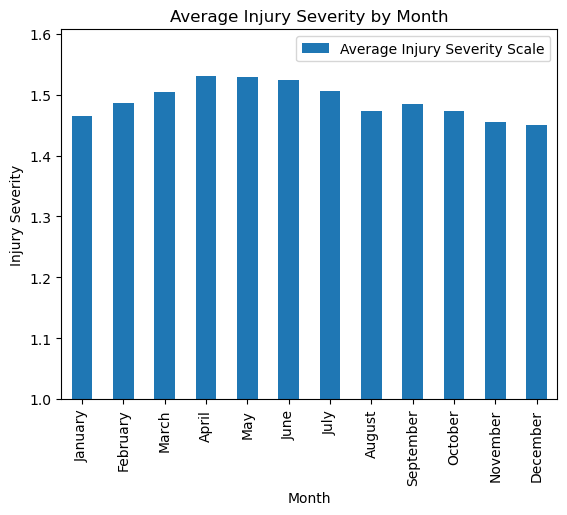

,Average Injury Severity Scale
Month,
January,1.464881
February,1.486131
March,1.505240
April,1.531044
May,1.529264
June,1.524236
July,1.506777
August,1.473826
September,1.485557


In [33]:
# Injury Severity Monthly Average

# Convert 'Date' to datetime format
injuries_filtered['Date'] = pd.to_datetime(injuries_filtered['Date'])

injuries_filtered['Month'] = injuries_filtered['Date'].dt.month

# Grouping by the 'Month' column and calculate the average injury severity for each month
monthly_avg_injury_severity = injuries_filtered.groupby('Month')['Injury Severity Scale'].mean().reset_index()

# Renaming columns
monthly_avg_injury_severity.columns = ['Month', 'Average Injury Severity Scale']

# Converting month numbers to their names
monthly_avg_injury_severity['Month'] = monthly_avg_injury_severity['Month'].apply(lambda x: pd.to_datetime(x, format='%m').strftime('%B'))

monthly_avg_injury_severity_indexed = monthly_avg_injury_severity.set_index('Month')

monthly_avg_injury_severity_indexed_chart = monthly_avg_injury_severity_indexed.plot(kind='bar')


plt.xlabel('Month')
plt.ylabel('Injury Severity')
plt.title('Average Injury Severity by Month')
plt.ylim(1)
plt.savefig("Resources/Images/injury_severity_average_by_month.png")

plt.show()
monthly_avg_injury_severity_indexed
